In [ ]:
# Using CNN TO Implement Scene_Recognization_With_Bag_of_Words

In [38]:
import torch
print(torch.__version__)

1.12.0+cu113


In [39]:
import os
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader,Subset
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
import numpy as np

#引入学习率调度器
from torch.optim.lr_scheduler import StepLR

In [40]:
# 数据集路径
data_dir="../Proj_3_Scene_Recognition_with_Bag_of_Words/dataset/101_ObjectCategories"

In [41]:


# 定义训练和验证数据集的转换
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((128, 128)),  # 调整图像大小
        transforms.RandomHorizontalFlip(),  # 随机水平翻转
        transforms.RandomRotation(15),  # 随机旋转
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # 颜色抖动
        transforms.ToTensor(),  # 转换为张量
        transforms.Normalize([0.5], [0.5])  # 归一化
    ]),
    'val': transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
}# 加载完整的数据集（不应用 transform）
full_dataset = datasets.ImageFolder(root=data_dir)

# 获取所有样本的索引和标签
indices = np.arange(len(full_dataset))
labels = [full_dataset.imgs[i][1] for i in indices]  # 获取每个样本的标签

# 使用 train_test_split 按照标签划分数据集
train_indices, val_indices = train_test_split(
    indices,
    test_size=0.2,
    stratify=labels,
    random_state=42
)

# 创建 Subset 数据集，应用 transform
train_dataset = Subset(datasets.ImageFolder(root=data_dir, transform=data_transforms['train']), train_indices)
val_dataset = Subset(datasets.ImageFolder(root=data_dir, transform=data_transforms['val']), val_indices)

# 创建数据加载器
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
#使用train_loader 和val_loader形成dataloaders  
            
dataloaders = {'train': train_loader, 'val': val_loader}
# 获取类别名称
class_names = full_dataset.classes
num_classes = len(class_names)
print(f'类别数: {num_classes}')

类别数: 102


In [53]:
#定义一个简单的CNN模型
class SimpleCNN_0(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN_0, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),  # 输出尺寸：32 x 64 x 64
     
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),  # 输出尺寸：64 x 32 x 32
        
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),  # 输出尺寸：128 x 16 x 16
         
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # 展平
        x = self.classifier(x)
        return x
    
    
#增加dropout层，减少过拟合
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),  # 输出尺寸：32 x 64 x 64
            nn.Dropout(0.25),  # 增加 Dropout
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),  # 输出尺寸：64 x 32 x 32
            nn.Dropout(0.25),  # 增加 Dropout
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),  # 输出尺寸：128 x 16 x 16
            nn.Dropout(0.25),  # 增加 Dropout
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # 展平
        x = self.classifier(x)
        return x

# 实例化模型
model = SimpleCNN(num_classes)

In [42]:
#定义相应的损失函数和优化器
# 使用交叉熵损失函数
criterion = nn.CrossEntropyLoss()

# 使用 Adam 优化器
optimizer = optim.Adam(model.parameters(), lr=0.001)
# 正则化策略
# 使用带权重衰减的 Adam 优化器
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# 使用 SGD 优化器
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

#定义学习率调度器
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [43]:
#训练模型
import time
import copy

def train_model(model, criterion, optimizer,scheduler,dataloaders, num_epochs=25,patience=5):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f'使用设备：{device}')
    model.to(device)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    #实现早停策略的参数
    epochs_no_improve = 0
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # 每个 epoch 有训练和验证阶段
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 设置模型为训练模式
            else:
                model.eval()   # 设置模型为评估模式

            running_loss = 0.0
            running_corrects = 0

            # 遍历数据
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 清零参数梯度
                optimizer.zero_grad()

                # 前向传播
                # 仅在训练阶段计算梯度
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 仅在训练阶段反向传播和优化
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 统计损失和准确率
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            # 如果是训练阶段，更新学习率
            if phase == 'train':
                scheduler.step()
                
            # 计算一个 epoch 的损失和准确率
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # 记录损失
            if phase == 'train':
                train_losses.append(epoch_loss)
                
            else:
                val_losses.append(epoch_loss)

            # 深度复制模型
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                
        print()
         # 检查是否早停
        if epochs_no_improve >= patience:
            print('Early stopping!')
            break
        
    print(f'最佳验证准确率: {best_acc:.4f}')

    # 加载最佳模型权重
    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses

# 开始训练
num_epochs = 50
patience = 20
model, train_losses, val_losses = train_model(model, criterion, optimizer,scheduler,dataloaders, num_epochs,patience)

使用设备：cuda:0
Epoch 1/50
----------
train Loss: 1.9356 Acc: 0.5236
val Loss: 1.6687 Acc: 0.5845

Epoch 2/50
----------
train Loss: 1.8879 Acc: 0.5321
val Loss: 1.6710 Acc: 0.5796

Epoch 3/50
----------
train Loss: 1.8211 Acc: 0.5401
val Loss: 1.6127 Acc: 0.6003

Epoch 4/50
----------
train Loss: 1.7837 Acc: 0.5491
val Loss: 1.6290 Acc: 0.5861

Epoch 5/50
----------
train Loss: 1.7690 Acc: 0.5517
val Loss: 1.5778 Acc: 0.6080

Epoch 6/50
----------
train Loss: 1.7038 Acc: 0.5642
val Loss: 1.5632 Acc: 0.6200

Epoch 7/50
----------
train Loss: 1.6942 Acc: 0.5651
val Loss: 1.5083 Acc: 0.6200

Epoch 8/50
----------
train Loss: 1.6370 Acc: 0.5758
val Loss: 1.5171 Acc: 0.6299

Epoch 9/50
----------
train Loss: 1.6359 Acc: 0.5805
val Loss: 1.4890 Acc: 0.6359

Epoch 10/50
----------
train Loss: 1.6149 Acc: 0.5796
val Loss: 1.5057 Acc: 0.6271

Epoch 11/50
----------
train Loss: 1.4927 Acc: 0.6129
val Loss: 1.4222 Acc: 0.6484

Epoch 12/50
----------
train Loss: 1.4235 Acc: 0.6254
val Loss: 1.4088 Ac

[1.935567590869296, 1.887939556510336, 1.8210799461346494, 1.7836784426512493, 1.7689978232224022, 1.7038272530268255, 1.6941757925878382, 1.6370190741994652, 1.6359289685423375, 1.6149349779929516, 1.4927208469407818, 1.4234597172055925, 1.3846850934781527, 1.3634211797707714, 1.352108800989752, 1.3588858615512809, 1.3293627062808628, 1.2949945700062682, 1.3168290521050672, 1.2935033533887674, 1.2944452428279962, 1.26667169924884, 1.278968390453701, 1.28529959002017, 1.2673093754872018, 1.2773043178648307, 1.2663944907817462] [1.6687006329890481, 1.670967591401982, 1.6127488734358448, 1.6289975778726753, 1.5778230785215532, 1.5631543376394932, 1.5083450259505367, 1.517118752491546, 1.4890189963393423, 1.5056614147111196, 1.4221975515291558, 1.408799698601791, 1.4066447730661416, 1.4020043163758409, 1.391441386146191, 1.3901432304841173, 1.3807549106416446, 1.3803384215405496, 1.3772406984770345, 1.3732536638154562, 1.3732335877718334, 1.3736094815800137, 1.370011498460097, 1.369604392

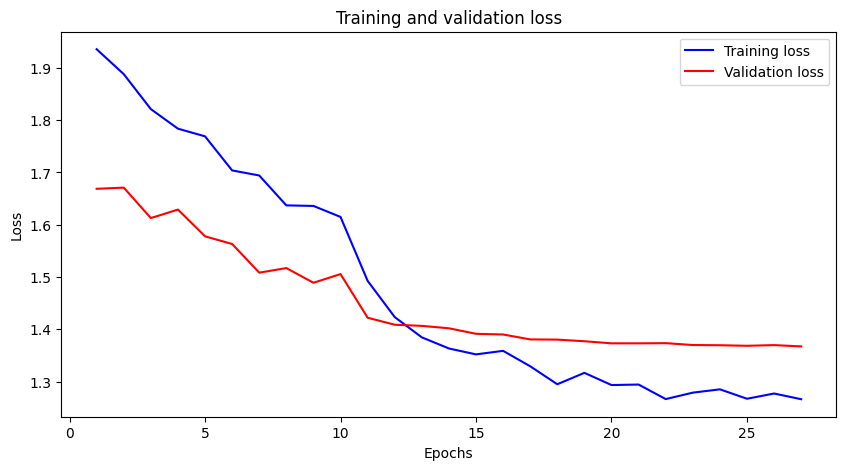

In [44]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)
epochs = range(1, len(train_losses) + 1)
print(train_losses,val_losses)
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, 'b-', label='Training loss')
plt.plot(epochs, val_losses, 'r-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [45]:
#保存相应的模型
# 保存模型
torch.save(model.state_dict(), 'scene_recognition_cnn_2.pth')

In [ ]:
#加载模型
#注意相应的加载模型的时候，需要保持相应的模型结构是一致的才可以的，否则加载的时候会出现相应的错误
model = SimpleCNN_0(num_classes)
model.load_state_dict(torch.load('scene_recognition_cnn.pth'))
model.eval()  # 设置为评估模式

def predict_image(image_path, model):
    from PIL import Image
    # 定义与训练时相同的转换
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])

    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    image = image.unsqueeze(0)  # 增加批次维度

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    image = image.to(device)
    model = model.to(device)

    with torch.no_grad():
        outputs = model(image)
        _, preds = torch.max(outputs, 1)
        predicted_class = class_names[preds[0]]
    return predicted_class

# 示例使用
image_path = '../Proj_3_Scene_Recognition_with_Bag_of_Words/dataset/test.jpg'
predicted_class = predict_image(image_path, model)
print(f'预测类别: {predicted_class}')

预测类别: cougar_face
